## Notebook Purpose

Quantitative evaluation of qdess recon experiments

In [1]:
import os, sys
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
import numpy as np
import torch

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.evaluate import calc_metrics, normalize_img

In [72]:
def plot_list(arr_list, clim=None):
    
    # stretch_factor = 0.8/(160/512) = 2.56 
    # 0.8 = slice thickness, 160 = FOV in phase encode direction and 512 = number of kspace samples in the phase direction
    STRETCH_FACTOR = 2.56 
    
    NUM_COLS = len(arr_list)
#     title_list = ['ground-truth', 'recon, 4x', 'recon, 6x', 'recon, 8x']
    title_list = ['ground_truth', 'dd+', 'u-net']
    
    fig = plt.figure(figsize=(20,20))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        ax.imshow(arr_list[idx], cmap='gray', clim=clim, aspect=(1./STRETCH_FACTOR))
        ax.set_title(title_list[idx], fontsize=20)
        ax.axis('off')

### define test set

based off `/bmrNAS/people/arjun/data/stanford-qDESS/annotations/v0.0.2/splits.xlsx`, which has pathology-relevant samples `MTR_065` and `MTR_066` in its test set

In [60]:
path = '/bmrNAS/people/arjun/data/qdess_knee_2020/files_recon_calib-16/'

MTR_ID_LIST = ['065', '066', '240', '156', '188', '199', '224', '198', '219', '096', '052', '196', '221', '241', '223', '178', '227', '099', '218', '248', '006', '005', '173', '048', '158', '080', '034', '144', '176', '244', '120', '235', '237', '030']
# fn_list = ['MTR_{}.h5'.format(f) for f in mtr_list]

# skip these samples b/c baselines have the incorrect dimensions
MTR_IDS_TO_SKIP = ['178', '223'] 
[MTR_ID_LIST.remove(mtr_id) for mtr_id in MTR_IDS_TO_SKIP]

[None, None]

### slices of clinical relevance

### load arjun baselines

In [85]:
path_baseline = '/bmrNAS/people/arjun/results/mtr/toy/recon_only/version_004/test_results/stanford_qdess_v0.0.2_test/'

def load_qdess_baseline(mtr_id, idx_kx=None):
    ''' given mtr_id e.g. MTR_123, load from pre-defined directory
              idx_kx: index in kx at which to get axial slice 
        loads .npy file of shape (x,y,z,1,2) 
        returns array of shape (y,z) '''
    
    arr = torch.from_numpy(np.load('{}MTR_{}.npy'.format(path_baseline, mtr_id))) # shape (x,y,z,1,2)
    
    if not idx_kx: # get central slice if unspecified
        idx_kx = arr.shape[0] // 2
    arr = arr[int(idx_kx), :, :, :, :]
    
    # combine real/complex values
    arr_new = torch.empty((arr.shape[0], arr.shape[1]), dtype=torch.complex64)
    arr_new.real = arr[:, :, 0, 0]
    arr_new.imag = arr[:, :, 0, 1]
    
    return np.array(torch.absolute(arr_new))   

### compute metrics

# TODO

- figure out why metrics (vif, msssim) not computed correctly
    - note: img_dc and img_bl have very different ranges
    - compare calculations to fastmri
- figure out plotting clim, i.e. w diff maps
- look at particular samples of interest
- look at clinically relevant slices from MTR_065, MTR_066
    - play with windowing, see if we can get one of akshay's four annotations as a good example
    - so far MTR_066, idx_kx=279 might be a candidate?
- create plotting utils for zoom, arrow

In [78]:
img_dc.max(), img_bl.max(), img_gt.max()

(14.676687, 75286830.0, 79391000.0)

In [68]:
path_recons = '/bmrNAS/people/dvv/out_qdess/accel_4x/echo1/'

NUM_SAMPS = len(MTR_ID_LIST)
NUM_VARS = 3 # ground-truth, our output, original baseline
NUM_METRICS = 4 # vif, msssim, ssim, psnr

im_list = np.empty((NUM_SAMPS,NUM_VARS,512,160))
metric_dc_list = np.empty((NUM_SAMPS, NUM_METRICS))
metric_bl_list = np.empty((NUM_SAMPS, NUM_METRICS))

for idx, mtr_id in enumerate(MTR_ID_LIST):

    img_gt = np.load('{}MTR_{}_gt.npy'.format(path_recons, mtr_id))
    img_dc = np.load('{}MTR_{}_dc.npy'.format(path_recons, mtr_id))
    img_bl = load_qdess_baseline(mtr_id)
    
    metric_dc_list[idx] = calc_metrics(img_dc, img_gt)
    metric_bl_list[idx] = calc_metrics(img_bl, img_gt)
    im_list[idx] = [img_gt, img_dc, img_bl]

print('dd+')
print(np.mean(metric_dc_list, axis=0))

print('\nu-net')
print(np.mean(metric_bl_list, axis=0))

dd+
[ 0.94187797         nan  0.86823532 32.88022284]

u-net
[ 0.1494047          nan  0.83903867 31.846727  ]


### echo2 results
4x accel
ssim ~N(0.772, 0.0535)
psnr ~N(32.8001, 1.487)

 6x accel
ssim ~N(0.7339, 0.0537)
psnr ~N(31.8721, 1.514)

 8x accel
ssim ~N(0.7166, 0.0505)
psnr ~N(31.4235, 1.1096)

### cast all range of pixel values to be on [0,1]

network output has .mean() ~2, while gt has .mean() ~20000

In [69]:
im_list_norm = np.empty(im_list.shape)

for idx_s, samp in enumerate(im_list): # for each sample    
    for idx_v, var in enumerate(samp): # for each variation of that sample
        
        im_list_norm[idx_s, idx_v] = (var - var.min()) * (1. / var.max())

### apply stretch factor to images

- 0.8/(160/512) = 2.56 stretch factor
    - 0.8 = slice thickness, 160 = FOV in phase encode direction and 512 = number of kspace samples in the phase direction
        - FOV: distance over which an MR image is acquired or displayed
- qdess data in shape [nc, kx, ky, kz] = [16, 512, 512, 160] 
    - take central slice in kx. then undersample in [ky, kz]
    - in-plane voxels [kx, ky] are taken at 0.3mm x 0.3mm and thru-plane voxels are taken at spacing of 0.8mm
        - here "in-plane" refers to the sagittal plane, even though we are sampling in [ky,kz] and hence viewing axial images

if we want to view each true voxel equally...

### TODO: reason through this using FOV and k-space notes in g doc

### make difference maps w gt

In [70]:
im_diff_list = np.empty(im_list.shape)

for idx_s, samp in enumerate(im_list_norm): # for each sample
    
    gt = samp[0]

    for idx_v, var in enumerate(samp): # for each variation of that sample

        if idx_v == 0:
            im_diff = np.zeros(gt.shape)
        else:
            var_norm = normalize_img(gt, var) # normalizes arg 2
            im_diff = np.abs(var_norm - gt)    
        
        im_diff_list[idx_s, idx_v]  = im_diff

SystemExit: 

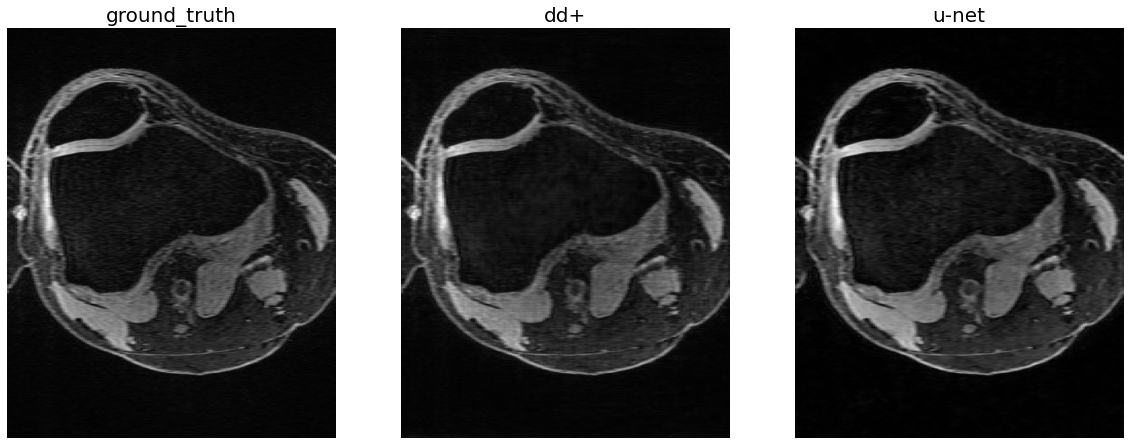

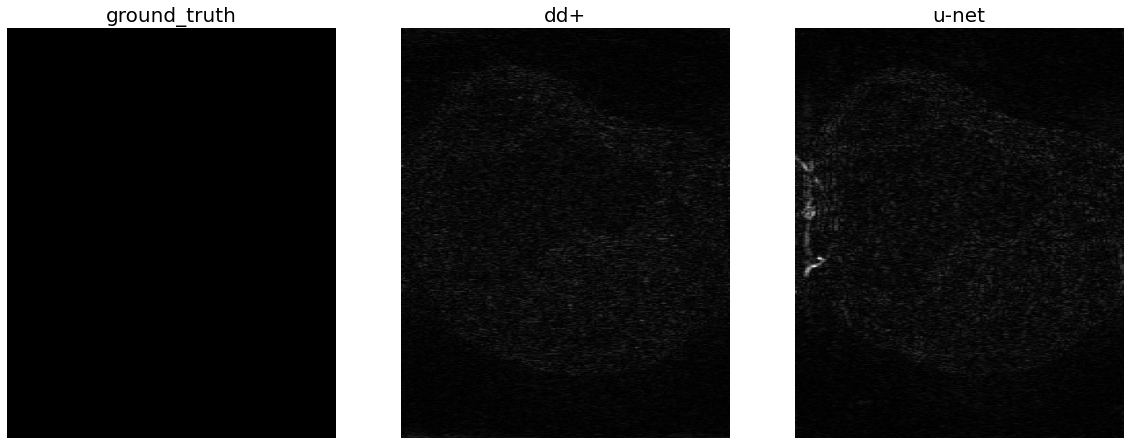

In [79]:
for idx in np.arange(NUM_SAMPS):
    plot_list(im_list_norm[idx])
    plot_list(im_diff_list[idx], clim=(0,im_diff_list[idx].max()))
    sys.exit()

### plot slices of clinical relevance

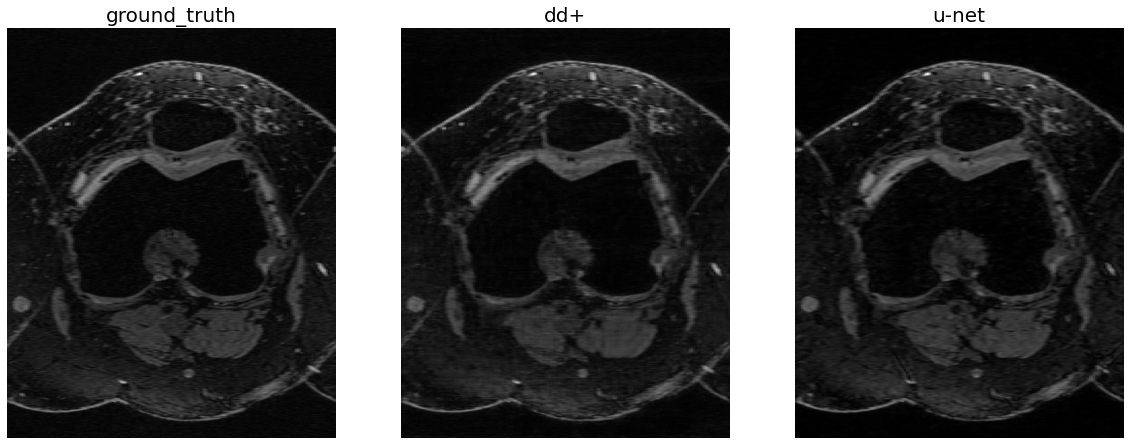

In [99]:
idx_kx_dict = {'MTR_065.h5': [219, 220, 221, 372, 373, 374],
               'MTR_066.h5': [277, 278, 279, 280]}

path_spec_slices = '/bmrNAS/people/dvv/out_qdess/specific_slices/accel_4x/echo1/'

mtr_id = '066' # '065' or '066'
idx_kx = '279'

img_gt = np.load('{}MTR_{}_gt_slice{}.npy'.format(path_spec_slices, mtr_id, idx_kx))
img_dc = np.load('{}MTR_{}_dc_slice{}.npy'.format(path_spec_slices, mtr_id, idx_kx))
img_bl = load_qdess_baseline(mtr_id, idx_kx=idx_kx)

plot_list([img_gt, img_dc, img_bl])
# plot_list([img_bl])